In [1]:
#LIMPIEZA Y MANIPULACION DE DATOS
import pandas as pd
import re
from unidecode import unidecode
import numpy as np

#FUNCIONES
from funciones_usisa_prediccion_ventas import *

#VISUALIZACION
import seaborn as sns
import matplotlib.pyplot as plt

#MODELO
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# LIMPIEZA Y MANIPULACIÓN DE DATOS

#### CARGAR Y EDITAR DATA NUEVO

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df_nuevo = pd.read_csv("tienda_online_nuevo.csv")

In [4]:
df_nuevo = todas_las_funciones_nuevo(df_nuevo)

#### CARGAR Y EDITAR DATA ANTIGUO

In [5]:
df_antiguo = pd.read_excel("tienda_online_antiguo.xlsx")

In [6]:
df_antiguo = todas_las_funciones_antiguo(df_antiguo)

#### CONCATENAR DF_NUEVO Y DF_ANTIGUO

In [7]:
df = concatenar(df_antiguo,df_nuevo)

# FRECUENCIA TIMESERIES - MENUSAL

In [8]:
timeseries_diario = agrupar_diario(df)
timeseries_mensual = timeseries_diario.resample('M').sum().reset_index()
timeseries_mensual = timeseries_mensual.set_index('fecha')
timeseries_mensual = timeseries_mensual.iloc[:-1] #ELIMINAMOS EL ULTIMO MES SI NO TENEMOS LOS DATOS COMPLETOS
timeseries_mensual['total_facturacion(€)'] = timeseries_mensual['total_facturacion(€)'].round(2)

In [9]:
timeseries_mensual

,total_pedidos,total_facturacion(€)
fecha,,
2017-12-31,23,2586.97
2018-01-31,6,371.00
2018-02-28,17,1941.47
2018-03-31,12,1299.58
2018-04-30,28,2076.92
...,...,...
2023-06-30,99,10791.42
2023-07-31,112,13687.77
2023-08-31,140,15208.20


In [10]:
#COMPORBACION: NO HAY DATOS FALTANTES 
comprobacion_saltos = timeseries_mensual.copy()
comprobacion_saltos['fecha'] = comprobacion_saltos.index
comprobacion_saltos['date_check'] = comprobacion_saltos['fecha'].diff()
comprobacion_saltos.date_check.value_counts()

31 days    41
30 days    23
28 days     5
29 days     1
Name: date_check, dtype: int64

# FACTURACIÓN MENSUAL

#### EDA - FACTURACIÓN MENSUAL

In [11]:
facturacion_mensual = timeseries_mensual.drop('total_pedidos', axis=1)

In [12]:
facturacion_mensual.index = pd.to_datetime(facturacion_mensual.index)

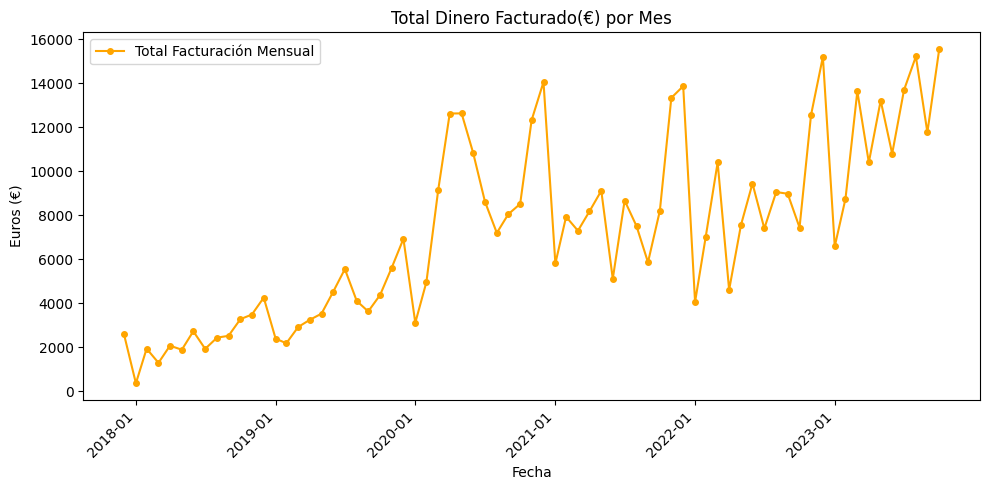

In [13]:
timeseries_facturacion_mensual(timeseries_mensual)

#### TRAIN / TEST SPLIT -  FACTURACIÓN MENSUAL

In [14]:
fecha_corte = pd.to_datetime('2023-08-01')  
train_fm = facturacion_mensual[facturacion_mensual.index < fecha_corte]
test_fm = facturacion_mensual[facturacion_mensual.index >= fecha_corte]
train_fm.index.freq = 'M'
test_fm.index.freq = 'M'

In [15]:
y_train_fm = train_fm['total_facturacion(€)']
y_test_fm = test_fm['total_facturacion(€)']

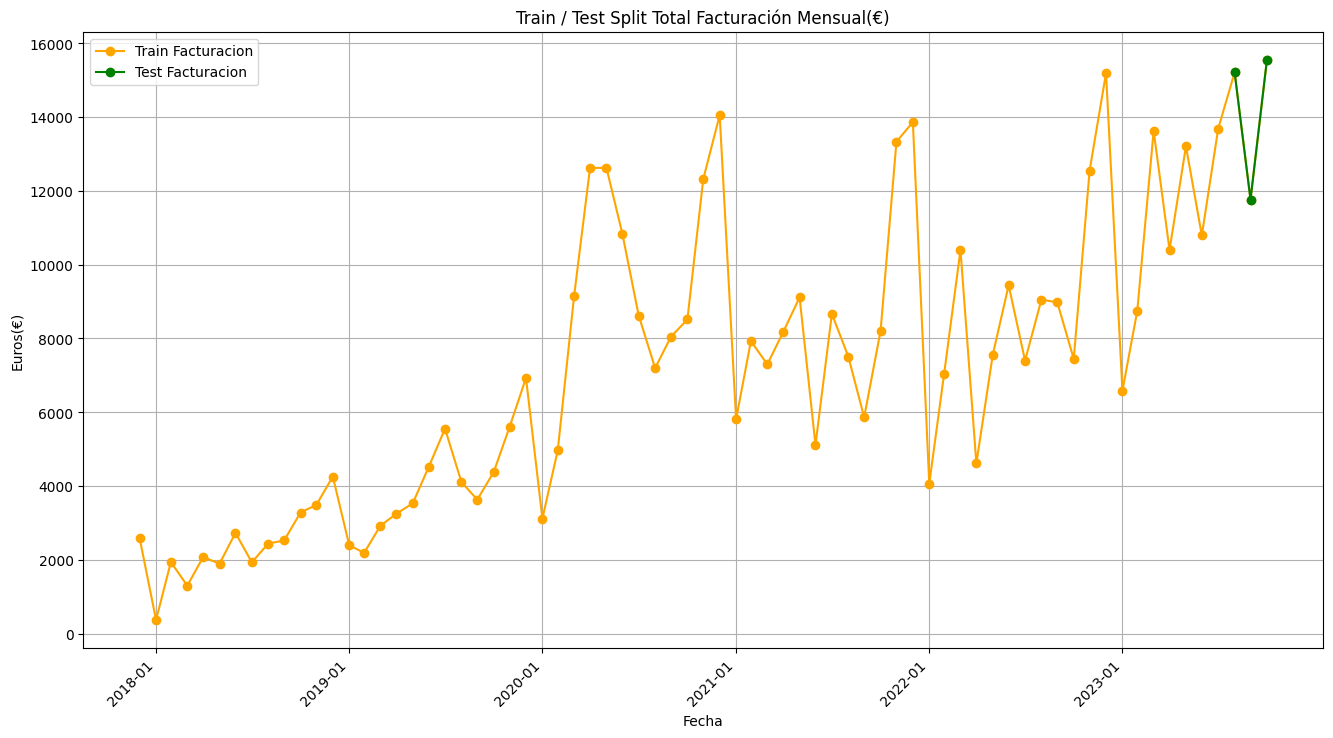

In [16]:
train_test_facturacion_mensual(facturacion_mensual, test_fm, y_test_fm)

#### MODELO AUTOARIMA -  FACTURACIÓN MENSUAL

In [17]:
autoarima_facturacion = pm.auto_arima(y_train_fm, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=12,             
                      d=None,         
                      seasonal=True,  
                      start_P=1,
                      D=1, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

In [18]:
autoarima_facturacion.fit(y_train_fm)

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
predictions_fm_autoarima, conf_int_fm = autoarima_facturacion.predict(len(y_test_fm), return_conf_int=True)

In [20]:
mse = mean_squared_error(y_test_fm, predictions_fm_autoarima)
mae = mean_absolute_error(y_test_fm, predictions_fm_autoarima)
r2 = r2_score(y_test_fm, predictions_fm_autoarima)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

Mean Squared Error: 2764474.907215103
Mean Absolute Error: 1191.4254741310167
R² Score: 0.05400970660222704


In [21]:
lower_conf_fm = conf_int_fm[:, 0]
upper_conf_fm = conf_int_fm[:, 1]

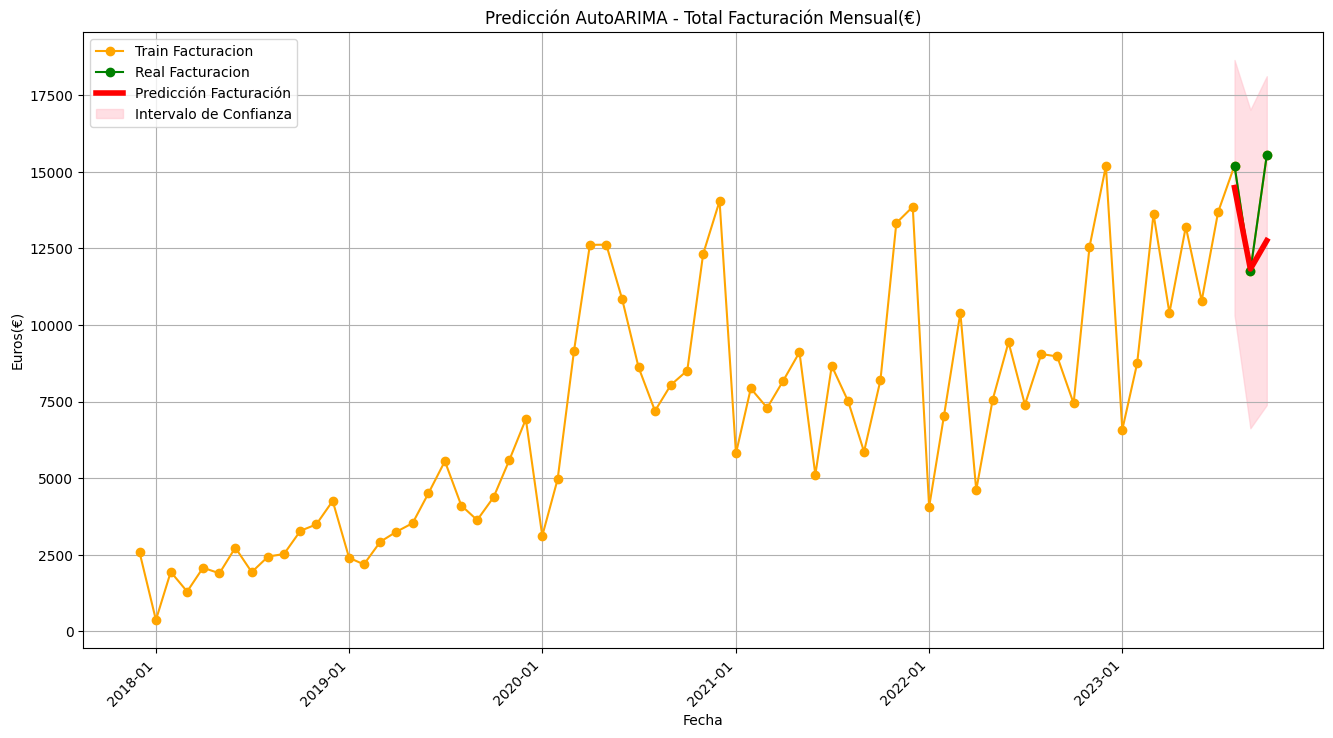

In [22]:
prediccion_facturacion_mensual(facturacion_mensual, test_fm, y_test_fm, predictions_fm_autoarima,lower_conf_fm, upper_conf_fm)

# PEDIDOS MENSUAL

#### EDA - PEDIDOS MENSUAL

In [23]:
pedidos_mensual = timeseries_mensual.drop('total_facturacion(€)', axis=1)

In [24]:
pedidos_mensual.index = pd.to_datetime(pedidos_mensual.index)

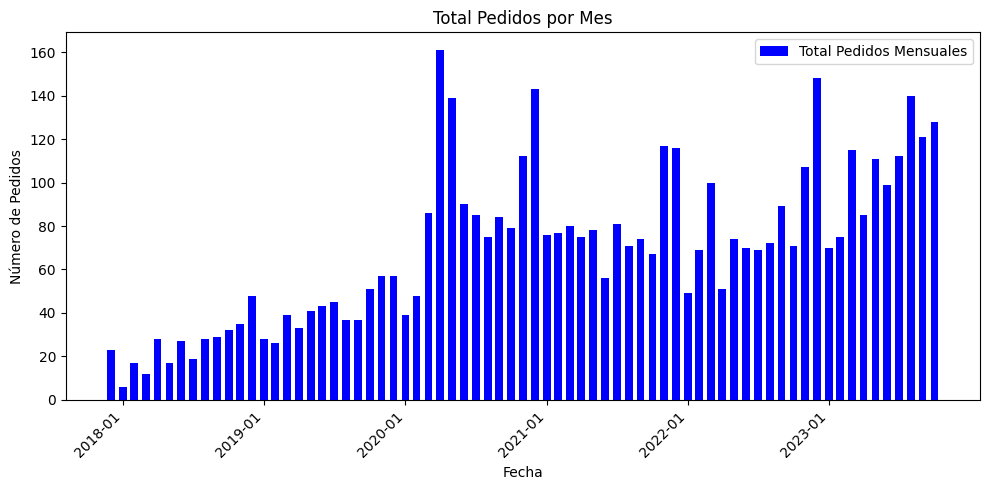

In [25]:
timeseries_pedidos_mensual(timeseries_mensual)

#### TRAIN / TEST SPLIT - PEDIDOS MENSUAL

In [26]:
fecha_corte = pd.to_datetime('2023-08-01')  
train_pm = pedidos_mensual[pedidos_mensual.index < fecha_corte]
test_pm = pedidos_mensual[pedidos_mensual.index >= fecha_corte]
train_pm.index.freq = 'M'
test_pm.index.freq = 'M'

In [27]:
y_train_pm = train_pm['total_pedidos']
y_test_pm = test_pm['total_pedidos']

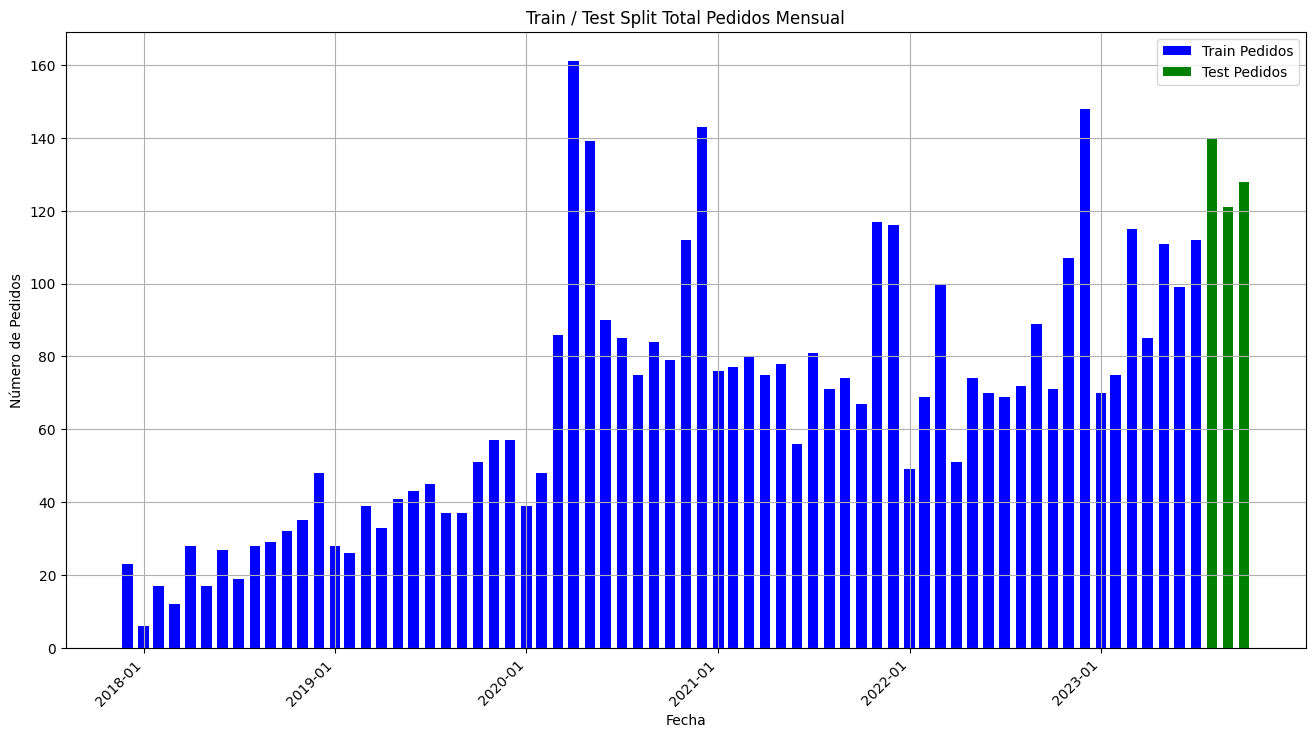

In [28]:
train_test_pedidos_mensual(pedidos_mensual, test_pm, y_test_pm)

#### MODELO AUTOARIMA -  PEDIDOS MENSUAL

In [29]:
autoarima_pedidos = pm.auto_arima(y_train_pm, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=12,             
                      d=None,         
                      seasonal=True,  
                      start_P=1,
                      D=1, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

In [30]:
autoarima_pedidos.fit(y_train_pm)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [31]:
predictions_pm_autoarima, conf_int_pm = autoarima_pedidos.predict(len(y_test_pm), return_conf_int=True)

In [32]:
mse = mean_squared_error(y_test_pm, predictions_pm_autoarima)
mae = mean_absolute_error(y_test_pm, predictions_pm_autoarima)
r2 = r2_score(y_test_pm, predictions_pm_autoarima)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

Mean Squared Error: 665.8239154894269
Mean Absolute Error: 23.635190753484622
R² Score: -9.816634006145925


In [33]:
lower_conf_pm = conf_int_pm[:, 0]
upper_conf_pm = conf_int_pm[:, 1]

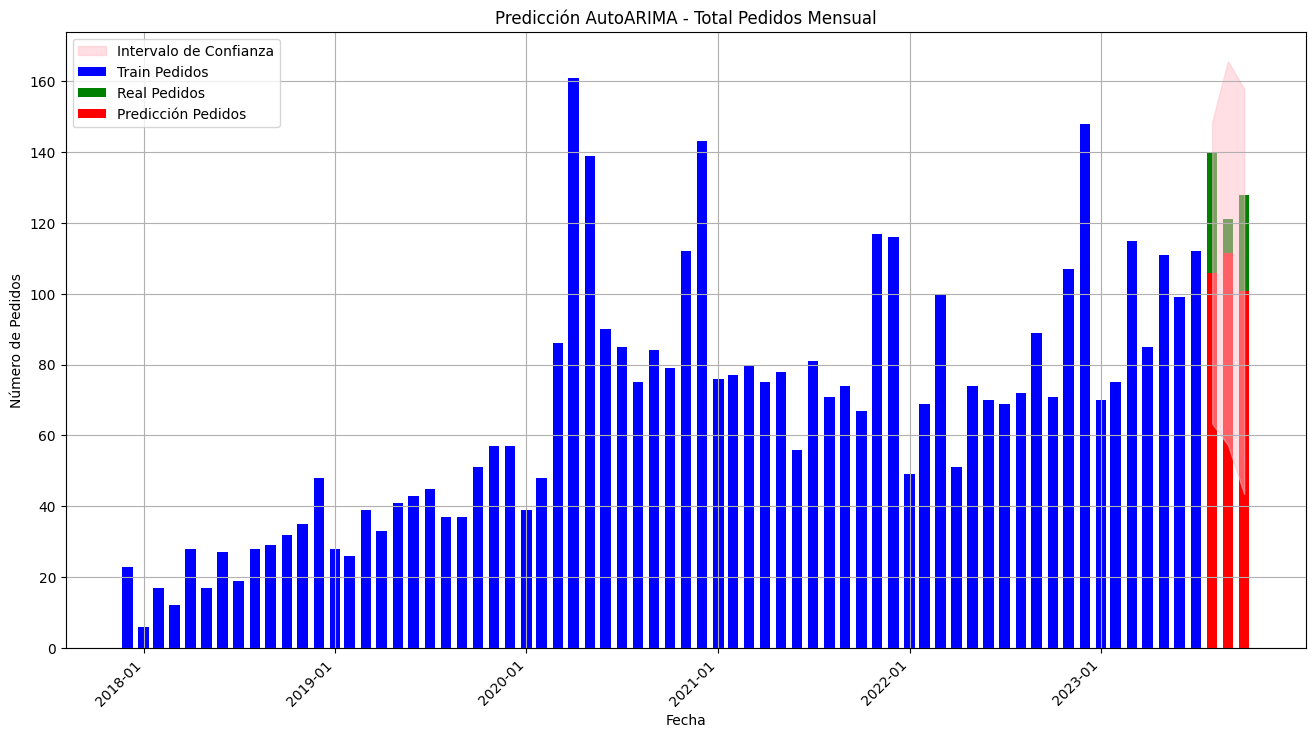

In [34]:
prediccion_pedidos_mensual(pedidos_mensual, test_pm, y_test_pm, predictions_pm_autoarima, lower_conf_pm, upper_conf_pm)